In [2]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/home/isaac/gimmeSAD"
#SIMOUT_DIR = os.path.join(GIMME_DIR, "1d_sims/")
SIMOUT_DIR = GIMME_DIR + "/1d_sims/"
OBSERVED_FILE = os.path.join(GIMME_DIR, "empirical_data/spider.obs")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
## Gather all the simulations from all the running hosts, assumes you're running on cattywampus
## Assumes you have sshpass installed
hosts = {"yowie":"isaac", "yeti":"isaac", "trashquatch":"labuser", "enterprise":"iovercast", "goatzilla":"isaac"}
passwd = {"yowie":"aardvark1", "yeti":"zastards", "trashquatch":"hickerlab", "enterprise":"watwatwat", "goatzilla":"hickerlab"}
simdir = {"yowie":"/Users/isaac/work/",
          "yeti":"/Volumes/WorkDrive/",
          "trashquatch":"/Users/labuser/Documents/isaac/",
          "enterprise":"/home/iovercast/",
          "goatzilla":"/home/isaac/"}

for host in hosts.keys():
    cmd = "sshpass -p \"{}\" scp -r {}@{}:{}gimmeSAD/1d_sims/* /tmp/sims/".format(passwd[host], hosts[host], host, simdir[host])
    print(cmd)
    os.system(cmd)


sshpass -p "aardvark1" scp -r isaac@yowie:/Users/isaac/work/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "watwatwat" scp -r iovercast@enterprise:/home/iovercast/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "hickerlab" scp -r labuser@trashquatch:/Users/labuser/Documents/isaac/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "hickerlab" scp -r isaac@goatzilla:/home/isaac/gimmeSAD/1d_sims/* /tmp/sims/


## Gather all the simulations into one huge simout file

In [3]:
REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")
outfile = open(REF_TABLE, "w")

ONEPER = True
REGULARIZE = False
DROPEQUILIBSIMS = True

files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
numsims = 0
outfile.write(open(files[0]).readlines()[0])
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## DO or don't regularlize the histograms
            if REGULARIZE:
                hist = np.array([int(x) for x in line.split()[7:]])
                if np.sum(hist):
                    tot = np.sum(hist)
                    hist = hist/float(tot)
                tmp = line.split()[:7] + map(str,hist)
                line = " ".join(tmp) + "\n"
                new_lines.append(line)

            ## Do or don't drop all the extra sims at equilibrium
            if line.split()[3] == "1" and DROPEQUILIBSIMS:
                pass
            else:
                new_lines.append(line)
        except:
            pass
    lines = new_lines
    ## Only choose one step per simulation?
    if lines and ONEPER:
        lines = [random.choice(lines)]
    ## Don't write blanks
    if lines:
        numsims += len(lines)
        outfile.write("".join(lines))
        outfile.write("\n")
outfile.close()

print("Processed {} simulations.".format(numsims))

Processed 14640 simulations.


In [291]:
new_lines[0]
print(numsims)

14640


## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

## Load the data into R

In [4]:
%%R -i OBSERVED_FILE -i REF_TABLE
library(abc)

OBS<- read.table(OBSERVED_FILE, header=TRUE)

## fill adds NA for any incomplete row
PRIOR <- read.table(REF_TABLE, header=TRUE, fill=TRUE)
print(PRIOR[1,])
print(OBS)

/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: abc.data

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: nnet

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: quantreg

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: SparseM

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘SparseM’


  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘packag

     K         c  step    X.equil colrate extrate  shannon bin_0 bin_1 bin_2
1 4606 0.0277614 10000 0.05579679  0.0279   0.007 1.689744    54    36     8
  bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     1     0     0     0     0     0     1
   shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1 3.737537     8    25     7     4     1     3     2     4     1     2


In [262]:
%%R
## Do or don't regularize the observed pi bins
if(TRUE){
    shan = OBS[1]
    tot = sum(OBS[2:11])
    OBS = data.frame(c(shan, OBS[2:11]/tot))
    print(OBS)
}

   shannon     bin_0     bin_1    bin_2      bin_3      bin_4      bin_5
1 3.737537 0.1403509 0.4385965 0.122807 0.07017544 0.01754386 0.05263158
       bin_6      bin_7      bin_8      bin_9
1 0.03508772 0.07017544 0.01754386 0.03508772


## Estimate % equilibrium using shannon index and 1d pi vector


### Rejection

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.2330182
0.01  0.2479963
0.05  0.3054559


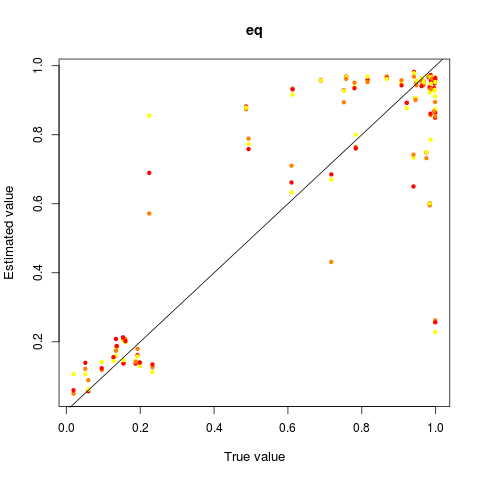

In [5]:
%%R
cv.res.rej <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(0.005,.05,.01), method="rejection")
print(summary(cv.res.rej))
plot(cv.res.rej)

### Loclinear regression

Prediction error based on a cross-validation sample of 100

             eq
0.005 0.1871502
0.01  0.1632591
0.05  0.1547410


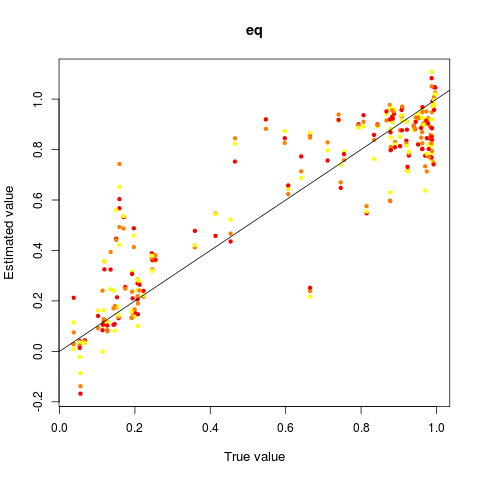

In [293]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Results with pi vectors regularized to sum to 1

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Do the ABC

In [8]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.01, method="rejection")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7:17], tol = 0.01, method = "rejection")
Data:
 abc.out$unadj.values (147 posterior samples)

                 eq
Min.:        0.0558
2.5% Perc.:  0.1257
Median:      0.8937
Mean:        0.7258
Mode:        0.9432
97.5% Perc.: 0.9939
Max.:        0.9997
                     eq
Min.:        0.05576649
2.5% Perc.:  0.12571320
Median:      0.89366351
Mean:        0.72579908
Mode:        0.94317444
97.5% Perc.: 0.99394146
Max.:        0.99971735
Error in plot.abc(res.abc, param = PRIOR[, "X.equil"]) : 
  Diagnostic plots can be displayed only when method is "loclinear", "neuralnet" or "ridge".FALSE


/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in plot.abc(res.abc, param = PRIOR[, "X.equil"]) : 
  Diagnostic plots can be displayed only when method is "loclinear", "neuralnet" or "ridge".FALSE

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In read.table(OBSERVED_FILE, header = TRUE) :
  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.p

In [316]:
%%R
res.abc$ss

        shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
  [1,] 3.257509    76    40     6     4     2     3     2     3     0     2
  [2,] 2.955322    42    35     8     4     0     1     4     2     0     2
  [3,] 3.447879    40    29    10     2     0     2     2     4     1     2
  [4,] 3.062392    51    44     5     6     0     2     2     2     0     1
  [5,] 3.251002    60    43     4     6     0     0     1     4     1     1
  [6,] 3.409516    72    55     9     3     1     2     3     2     1     2
  [7,] 2.131541    37    33     4     4     2     2     3     3     1     1
  [8,] 3.445052    36    36    14     5     4     3     1     4     0     1
  [9,] 2.890917    42    38     3     2     1     3     1     2     0     1
 [10,] 2.945705    19    19    12     4     1     1     0     3     0     1
 [11,] 3.072906    59    58    12     5     2     3     1     2     1     2
 [12,] 3.454007    50    37     9     2     2     3     1     3     1     1
 [13,] 2.712

## Estimate colonization rate using shannon index and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.2403154
0.01  0.2226436
0.05  0.2119116


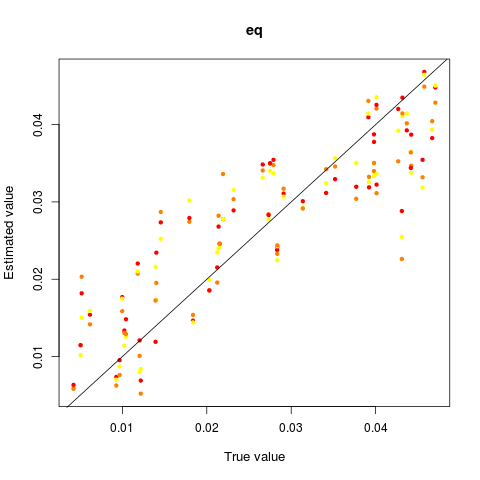

In [10]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,7:17], nval=50, tols=c(.005, .01, 0.05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(colrate = PRIOR[, "colrate"]), 
    sumstat = PRIOR[, 7:17], tol = 0.01, method = "loclinear")
Data:
 abc.out$adj.values (147 posterior samples)
Weights:
 abc.out$weights

                       colrate
Min.:                   0.0004
Weighted 2.5 % Perc.:   0.0023
Weighted Median:        0.0055
Weighted Mean:          0.0063
Weighted Mode:          0.0048
Weighted 97.5 % Perc.:  0.0134
Max.:                   0.0163
                            colrate
Min.:                  0.0004368663
Weighted 2.5 % Perc.:  0.0023367502
Weighted Median:       0.0055004629
Weighted Mean:         0.0062517614
Weighted Mode:         0.0048123951
Weighted 97.5 % Perc.: 0.0133890474
Max.:                  0.0163424358


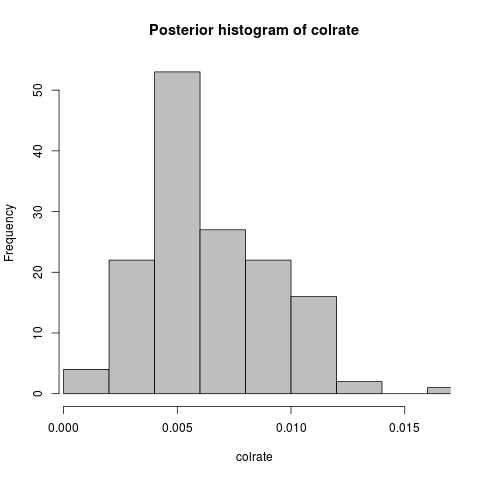

In [9]:
%%R
res.abc = abc(target=OBS, param=data.frame(colrate=PRIOR[,"colrate"]), sumstat=PRIOR[,7:17], tol=0.01, method="loclinear")
print(summary(res.abc))
hist(res.abc)
#plot(res.abc, param=PRIOR[,"colrate"])

## Estimate shannon using only 1d pi vector

Prediction error based on a cross-validation sample of 100

           shan
0.005 0.2953599
0.01  0.2629440
0.05  0.2589105


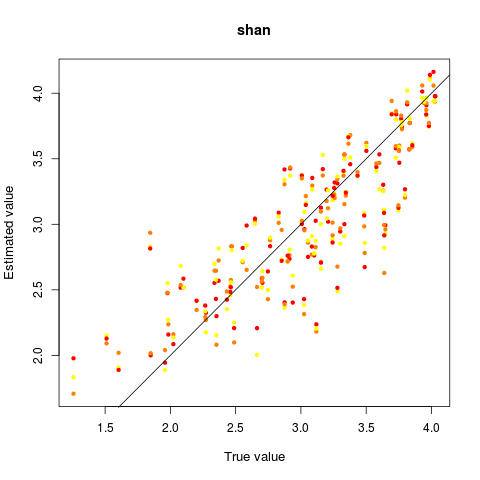

In [318]:
%%R
cv.res.reg <- cv4abc(data.frame(shan=PRIOR[,"shannon"]), PRIOR[,8:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[2:11], param = data.frame(shan = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 8:17], tol = 0.05, method = "loclinear")
Data:
 abc.out$adj.values (732 posterior samples)
Weights:
 abc.out$weights

                         shan
Min.:                  1.5443
Weighted 2.5 % Perc.:  2.6642
Weighted Median:       3.3170
Weighted Mean:         3.2989
Weighted Mode:         3.3305
Weighted 97.5 % Perc.: 3.9278
Max.:                  4.2186
                           shan
Min.:                  1.544262
Weighted 2.5 % Perc.:  2.664221
Weighted Median:       3.317048
Weighted Mean:         3.298896
Weighted Mode:         3.330506
Weighted 97.5 % Perc.: 3.927816
Max.:                  4.218637


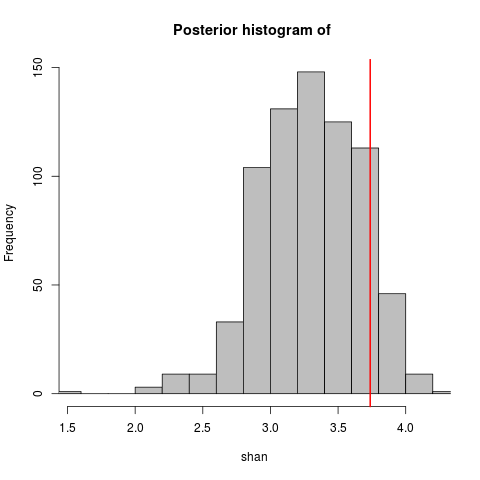

In [319]:
%%R
res.abc = abc(target=OBS[2:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,8:17], tol=0.05, method="loclinear")
print(summary(res.abc))
hist(res.abc, true=3.737537, cap="", breaks=10)
#plot(res.abc, param=PRIOR[,"shannon"])

## Estimate %equil using only 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.7258480
0.01  0.7412858
0.05  0.7583425


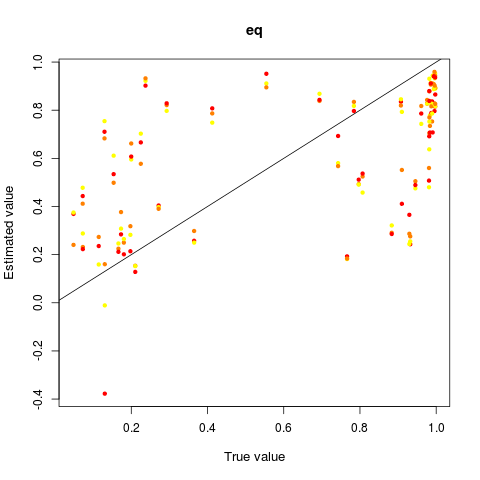

In [321]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,9:17], nval=50, tols=c(.005, .01, .05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

### Would be good to implement a 'veil line' for undetected species in the empirical dataset

We can fake this by just dropping the singleton bin, here's the code w/o the veil line
`res.abc = abc(target=OBS[2:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,8:17], tol=0.05, method="neuralnet")`

12345678910
12345678910
Call: 
abc(target = OBS[3:11], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 9:17], tol = 0.01, method = "neuralnet")
Data:
 abc.out$adj.values (147 posterior samples)
Weights:
 abc.out$weights

                            eq
Min.:                  -1.4685
Weighted 2.5 % Perc.:   0.5213
Weighted Median:        0.5934
Weighted Mean:          0.6212
Weighted Mode:          0.5721
Weighted 97.5 % Perc.:  0.7708
Max.:                   1.1289
                               eq
Min.:                  -1.4685290
Weighted 2.5 % Perc.:   0.5213028
Weighted Median:        0.5933691
Weighted Mean:          0.6211661
Weighted Mode:          0.5721282
Weighted 97.5 % Perc.:  0.7707698
Max.:                   1.1289119


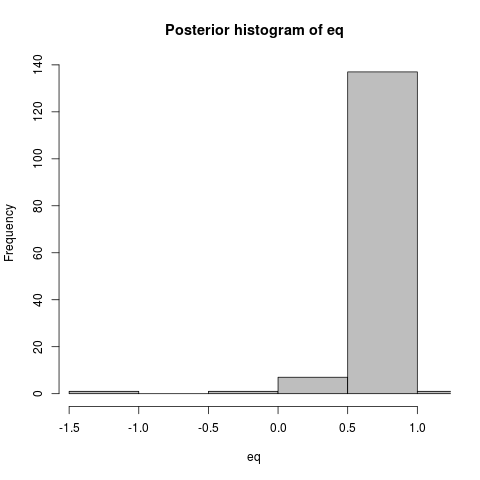

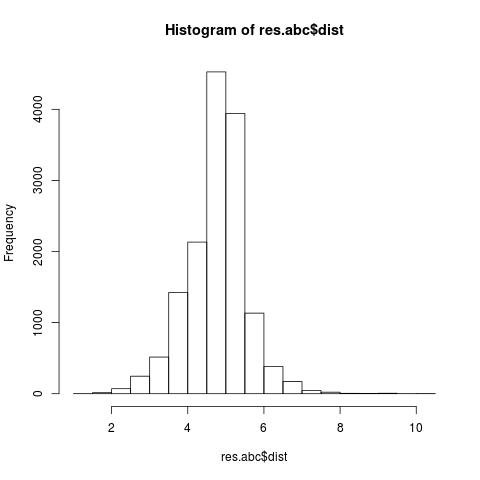

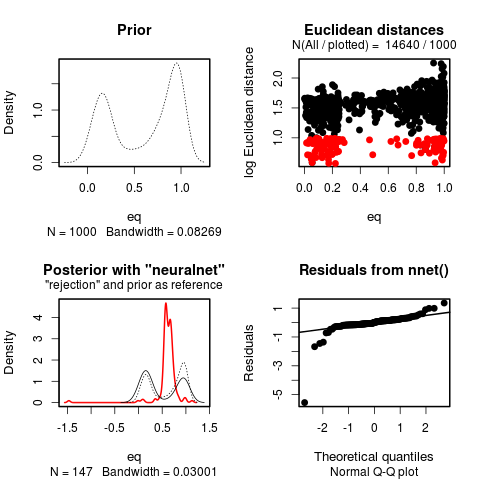

In [79]:
%%R
res.abc = abc(target=OBS[3:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,9:17], tol=0.01, method="neuralnet")
print(summary(res.abc))
#print(res.abc$ss)
hist(res.abc)
hist(res.abc$dist)
plot(res.abc, param=PRIOR[,"X.equil"])


## Prior goodness of fit test for retained simulations

[25  7  4  1  3  2  4  1  2]
(9,)
(147, 9)
[[50  8  6  1  1  0  3  1  2]
 [26  9  3  1  3  1  2  1  1]]
(148, 9)
[25  7  4  1  3  2  4  1  2]
explained variance ratio (first two components): [ 0.95945667  0.01952842]


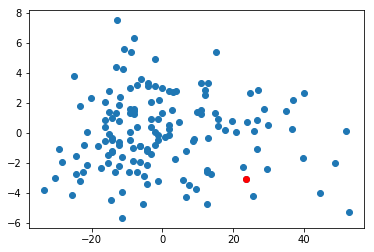

In [80]:
%R -o out out=res.abc$ss 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([int(x) for x in open(OBSERVED_FILE).readlines()[1].split()[2:]])
print(OBS)
print(OBS.shape)
print(out.shape)
print(out[0:2])

dat = np.vstack([out, OBS])
print(dat.shape)
print(dat[-1])
pca = PCA(n_components=2)
X_r = pca.fit(out).transform(out)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure()
x, y = zip(*X_r)
plt.scatter(x, y)
plt.scatter(x[-1], y[-1], c="r")

(array([ 28.,  26.,  17.,  16.,  10.,   4.,   5.,  11.,   6.,   1.,   3.,
          5.,   4.,   2.,   1.,   2.,   2.,   1.,   1.,   2.]),
 array([  3.16227766,   6.45923252,   9.75618737,  13.05314223,
         16.35009709,  19.64705195,  22.9440068 ,  26.24096166,
         29.53791652,  32.83487138,  36.13182623,  39.42878109,
         42.72573595,  46.0226908 ,  49.31964566,  52.61660052,
         55.91355538,  59.21051023,  62.50746509,  65.80441995,  69.10137481]),
 <a list of 20 Patch objects>)

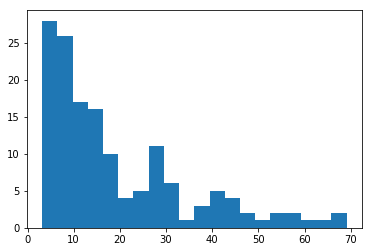

In [76]:
from scipy.spatial.distance import euclidean

dist = []
for vec in out:
    dist.append(euclidean(vec, OBS))
plt.hist(dist, bins=20)

## Estimate %equil using only shannon

Prediction error based on a cross-validation sample of 100

             eq
0.005 0.3428286
0.01  0.3486149
0.05  0.3220264


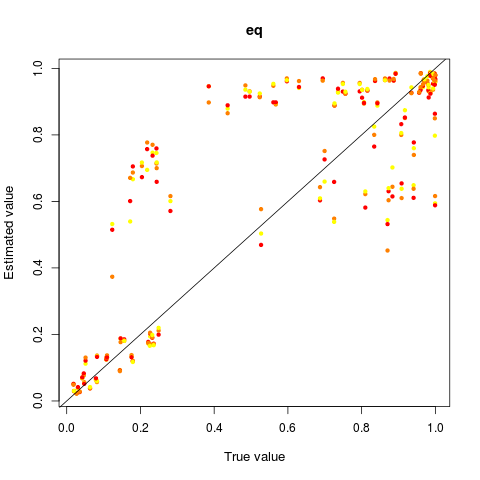

In [329]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7], nval=100, tols=c(.005, .01, .05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[, 1], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7], tol = 0.005, method = "loclinear")
Data:
 abc.out$adj.values (475 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.2624
Weighted 2.5 % Perc.:  0.3349
Weighted Median:       0.9949
Weighted Mean:         0.8385
Weighted Mode:         0.9961
Weighted 97.5 % Perc.: 1.0014
Max.:                  1.0014
                              eq
Min.:                  0.2623735
Weighted 2.5 % Perc.:  0.3348801
Weighted Median:       0.9949215
Weighted Mean:         0.8385153
Weighted Mode:         0.9961328
Weighted 97.5 % Perc.: 1.0013968
Max.:                  1.0013999


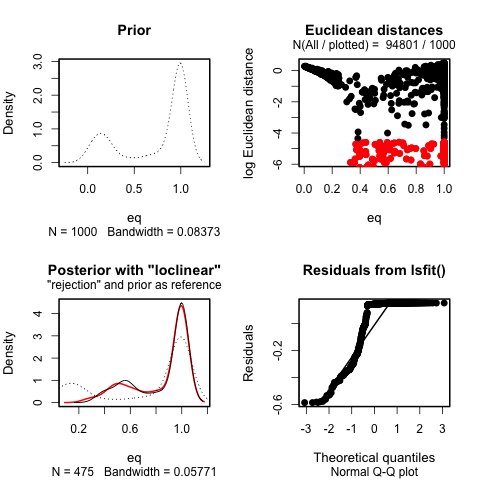

In [96]:
%%R
res.abc = abc(target=OBS[,1], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7], tol=0.005, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])

## Estimate island size using shannon and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.001 0.6453266
0.005 0.3867152
0.01  0.3609488
0.05  0.3812574
0.1   0.3750593


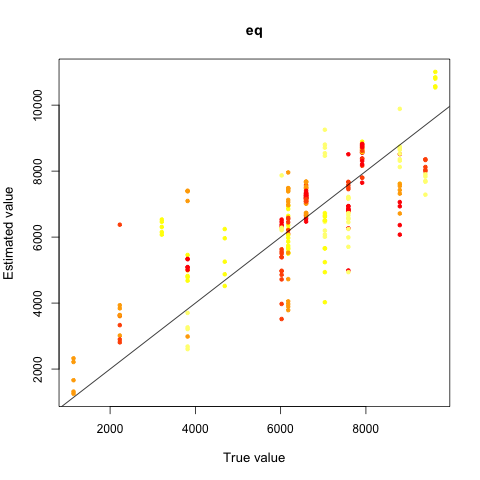

In [74]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"K"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "K"]), sumstat = PRIOR[, 
    7:17], tol = 0.05, method = "loclinear")
Data:
 abc.out$adj.values (4741 posterior samples)
Weights:
 abc.out$weights

                              eq
Min.:                   4237.161
Weighted 2.5 % Perc.:   5431.662
Weighted Median:        7963.660
Weighted Mean:          7908.706
Weighted Mode:          7764.804
Weighted 97.5 % Perc.:  9640.701
Max.:                  11308.365
                              eq
Min.:                   4237.161
Weighted 2.5 % Perc.:   5431.662
Weighted Median:        7963.660
Weighted Mean:          7908.706
Weighted Mode:          7764.804
Weighted 97.5 % Perc.:  9640.701
Max.:                  11308.365


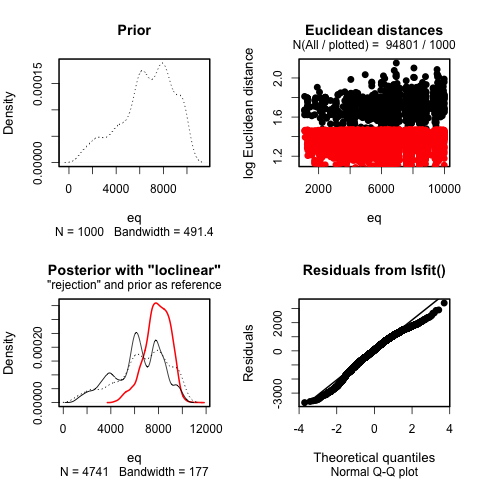

In [95]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"K"]), sumstat=PRIOR[,7:17], tol=0.05, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"K"])

# Co-estimate island size and %equil 

## Estimate island size/%equil using shannon and 1d pi vector

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = OBS, param = data.frame(k = PRIOR[, "K"], eq = PRIOR[, 
    "X.equil"]), sumstat = PRIOR[, 7:17], tol = 0.05, method = "loclinear")
Data:
 abc.out$adj.values (3679 posterior samples)
Weights:
 abc.out$weights

                                k         eq
Min.:                   3876.3373     0.1729
Weighted 2.5 % Perc.:   5462.2696     0.6628
Weighted Median:        8074.7916     0.8094
Weighted Mean:          7976.6834     0.8072
Weighted Mode:          7728.4728     0.8113
Weighted 97.5 % Perc.:  9545.4466     0.9480
Max.:                  10380.3491     1.1160
                                  k           eq
Min.:                  3.876337e+03 1.729484e-01
Weighted 2.5 % Perc.:  5.462270e+03 6.628112e-01
Weighted Median:       8.074792e+03 8.094355e-01
Weighted Mean:         7.976683e+03 8.071694e-01
Weighted Mode:         7.728473e+03 8.112688e-01
Weighted 97.5 % Perc.: 9.545447e+03 9.479953e-01
Max.:                  1.038035e+04 1.116049e+00


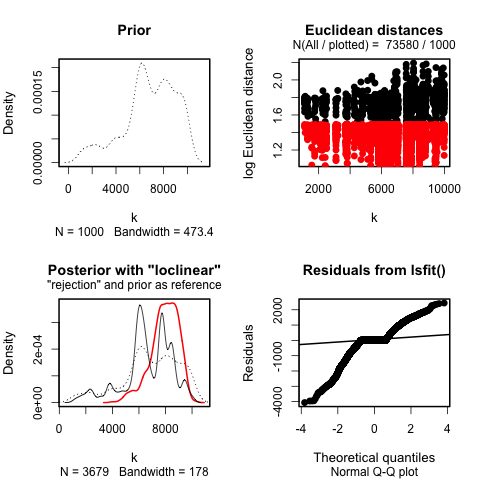

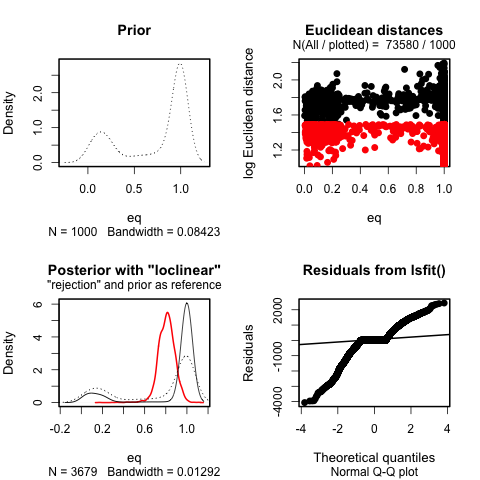

In [57]:
%%R
res.abc = abc(target=OBS, param=data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.05, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]))

## All crap below here

In [22]:
ss

NameError: name 'ss' is not defined